In [1]:
import os, h5py
import gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-05-27 19:09:55.194614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 19:09:55.355094: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 19:09:55.418637: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 19:09:56.069169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
def load_lentiMPRA_data(file):
    '''
    load Train/Test/Val lentiMPRA data
    '''
    data = h5py.File(file, 'r')

    # train
    X_train = np.array(data['Train']['X'])
    y_train = np.array(data['Train']['y'])

    # test
    X_test = np.array(data['Test']['X'])
    y_test = np.array(data['Test']['y'])

    # val
    X_val = np.array(data['Val']['X'])
    y_val = np.array(data['Val']['y'])

    return X_train, y_train, X_test, y_test, X_val, y_val

filename = 'K562_data_with_aleatoric.h5'
x_train, y_train, x_test, y_test, x_valid, y_valid = load_lentiMPRA_data(filename)

N, L, A = x_valid.shape

print(x_train.shape)
print(y_test.shape)

(180564, 230, 4)
(22571, 2)


In [3]:

def gaussian_nll_loss(y_true, y_pred):
    mean = tf.expand_dims(y_pred[:,0], axis=1)
    log_variance = tf.expand_dims(y_pred[:,1], axis=1)

    # Calculate the negative log-likelihood
    mse = keras.losses.mean_squared_error(y_true, mean)
    variance = tf.exp(log_variance)
    nll = 0.5 * (tf.math.log(2 * np.pi * variance) + mse / variance)

    # Return the average NLL across the batch
    return tf.reduce_mean(nll)
    

def laplace_nll_loss(y_true, y_pred):
    mu = tf.expand_dims(y_pred[:,0], axis=1)
    log_b = tf.expand_dims(y_pred[:,1], axis=1)

    # Calculate the absolute error
    abs_error = tf.abs(y_true - mu)

    # Calculate the negative log-likelihood
    b = tf.exp(log_b)
    nll = abs_error / b + log_b + tf.math.log(2.0)

    # Return the average NLL across the batch
    return tf.reduce_mean(nll)


def cauchy_nll_loss(y_true, y_pred):
    mu = tf.expand_dims(y_pred[:,0], axis=1)
    log_b = tf.expand_dims(y_pred[:,1], axis=1)

    # Calculate the negative log-likelihood
    b = tf.exp(log_b)
    nll = tf.math.log(np.pi * b) + tf.math.log(1 + tf.square((y_true - mu) / b))

    # Return the average NLL across the batch
    return tf.reduce_mean(nll)



In [4]:
import keras.layers as kl
def lentiMPRA(input_shape):
    '''
    CNN for predicting lentiMPRA data
    if aleatoric=True, predict aleatoric uncertainty
    if epistemic=True, predict epistemic uncertainty 
    '''

    def residual_block(input_layer, filter_size, activation='relu', dilated=5):
        '''
        define residual block for CNN
        '''
        factor = []
        base = 2
        for i in range(dilated):
            factor.append(base**i)
        num_filters = input_layer.shape.as_list()[-1]

        nn = kl.Conv1D(filters=num_filters,
                                        kernel_size=filter_size,
                                        activation=None,
                                        use_bias=False,
                                        padding='same',
                                        # dilation_rate=1, #commenting out bc default
                                        )(input_layer)
        nn = kl.BatchNormalization()(nn)
        for f in factor:
            nn = kl.Activation('relu')(nn)
            nn = kl.Dropout(0.1)(nn)
            nn = kl.Conv1D(filters=num_filters,
                                            kernel_size=filter_size,
                                            # strides=1, # commenting out bc default
                                            activation=None,
                                            use_bias=False,
                                            padding='same',
                                            dilation_rate=f,
                                            )(nn)
            nn = kl.BatchNormalization()(nn)
        nn = kl.add([input_layer, nn])
        return kl.Activation(activation)(nn)

    inputs = kl.Input(shape=input_shape)
    x = kl.Conv1D(196, kernel_size=19, padding='same')(inputs)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('silu')(x)
    x = kl.Dropout(0.2)(x)
    x = residual_block(x, 3, activation='silu', dilated=5)
    x = kl.Dropout(0.2)(x)
    x = kl.MaxPooling1D(5)(x) # 55

    x = kl.Conv1D(256, kernel_size=7, padding='same')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('silu')(x)
    x = kl.Dropout(0.2)(x)
    x = kl.MaxPooling1D(5)(x) # 10

    #   x = kl.Conv1D(256, kernel_size=5, padding='same')(x)
    #   x = kl.BatchNormalization()(x)
    #   x = kl.Activation('relu')(x)
    #   x = kl.Dropout(0.2)(x)
    #   x = kl.MaxPooling1D(3)(x) # 10

    x = kl.Dense(256)(x)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('silu')(x)
    x = kl.Dropout(0.5)(x)

    x = kl.GlobalAveragePooling1D()(x)
    x = kl.Flatten()(x)

    x = kl.Dense(256)(x)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('silu')(x)
    x = kl.Dropout(0.5)(x)

    outputs = kl.Dense(2, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model 




In [5]:

keras.backend.clear_session()
gc.collect()

model = lentiMPRA((L,A))
model.compile(keras.optimizers.Adam(lr=0.001), loss=cauchy_nll_loss)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])

2024-05-27 19:10:12.542156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 19:10:12.557993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 19:10:12.558122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 19:10:12.558667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Epoch 1/100


2024-05-27 19:10:16.054509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-05-27 19:10:16.790023: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 19:10:16.790415: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 19:10:16.790424: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-27 19:10:16.790775: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 19:10:16.790804: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-27 19:10:17.363580: I tensorflow/stream_executor/cuda/c

1411/1411 [==============================] - 47s 31ms/step - loss: 0.7840 - val_loss: 0.6542 - lr: 0.0010
Epoch 2/100
1411/1411 [==============================] - 43s 30ms/step - loss: 0.6464 - val_loss: 0.6477 - lr: 0.0010
Epoch 3/100
1411/1411 [==============================] - 43s 31ms/step - loss: 0.6400 - val_loss: 0.6449 - lr: 0.0010
Epoch 4/100
1411/1411 [==============================] - 43s 30ms/step - loss: 0.6361 - val_loss: 0.6276 - lr: 0.0010
Epoch 5/100
1411/1411 [==============================] - 43s 30ms/step - loss: 0.6323 - val_loss: 0.6278 - lr: 0.0010
Epoch 6/100
1411/1411 [==============================] - 43s 31ms/step - loss: 0.6286 - val_loss: 0.6371 - lr: 0.0010
Epoch 7/100
1411/1411 [==============================] - ETA: 0s - loss: 0.6249
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1411/1411 [==============================] - 44s 31ms/step - loss: 0.6249 - val_loss: 0.6285 - lr: 0.0010
Epoch 8/100
1411/1411 [==================

In [6]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(pred, Y, task):
    mse = mean_squared_error(Y[:,0], pred[:,0])
    pcc = stats.pearsonr(Y[:,0], pred[:,0])[0]
    scc = stats.spearmanr(Y[:,0], pred[:,0])[0]
    print(' MSE ' + task + ' = ' + str("{0:0.3f}".format(mse)))
    print(' PCC ' + task + ' = ' + str("{0:0.3f}".format(pcc)))
    print(' SCC ' + task + ' = ' + str("{0:0.3f}".format(scc)))

# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred,  y_test, "mean")


uncertainty = np.exp(pred[:,1])

task = 'aleatoric'
mse = mean_squared_error(y_test[:,1], uncertainty)
pcc = stats.pearsonr(y_test[:,1], uncertainty)[0]
scc = stats.spearmanr(y_test[:,1], uncertainty)[0]
print(' MSE ' + task + ' = ' + str("{0:0.3f}".format(mse)))
print(' PCC ' + task + ' = ' + str("{0:0.3f}".format(pcc)))
print(' SCC ' + task + ' = ' + str("{0:0.3f}".format(scc)))



45/45 [==============================] - 2s 37ms/step
 MSE mean = 0.311
 PCC mean = 0.645
 SCC mean = 0.609
 MSE aleatoric = 0.025
 PCC aleatoric = 0.211
 SCC aleatoric = 0.214


In [16]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(pred, Y, task):
    mse = mean_squared_error(Y[:,0], pred[:,0])
    pcc = stats.pearsonr(Y[:,0], pred[:,0])[0]
    scc = stats.spearmanr(Y[:,0], pred[:,0])[0]
    print(' MSE ' + task + ' = ' + str("{0:0.3f}".format(mse)))
    print(' PCC ' + task + ' = ' + str("{0:0.3f}".format(pcc)))
    print(' SCC ' + task + ' = ' + str("{0:0.3f}".format(scc)))

# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred,  y_test, "mean")


45/45 [==============================] - 2s 39ms/step
 MSE K562 = 0.191
 PCC K562 = 0.760
 SCC K562 = 0.703


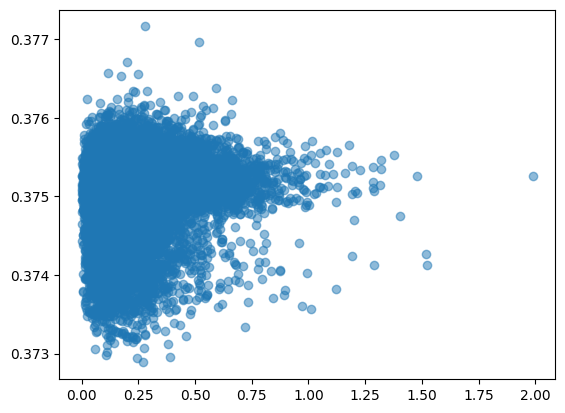

In [20]:
plt.scatter(y_test[:,1], np.sqrt(np.exp(pred[:,1])), alpha=0.5)

In [21]:

uncertainty = np.sqrt(np.exp(pred[:,1]))

task = 'aleatoric'
mse = mean_squared_error(y_test[:,1], uncertainty)
pcc = stats.pearsonr(y_test[:,1], uncertainty)[0]
scc = stats.spearmanr(y_test[:,1], uncertainty)[0]
print(' MSE ' + task + ' = ' + str("{0:0.3f}".format(mse)))
print(' PCC ' + task + ' = ' + str("{0:0.3f}".format(pcc)))
print(' SCC ' + task + ' = ' + str("{0:0.3f}".format(scc)))

 MSE aleatoric = 0.045
 PCC aleatoric = 0.106
 SCC aleatoric = 0.121


(array([7.000e+00, 3.600e+01, 6.100e+01, 1.970e+02, 3.350e+02, 4.780e+02,
        5.680e+02, 6.460e+02, 1.055e+03, 4.687e+03, 7.862e+03, 4.426e+03,
        1.624e+03, 4.450e+02, 1.110e+02, 2.300e+01, 4.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.37288588, 0.37309971, 0.37331355, 0.37352735, 0.37374118,
        0.37395501, 0.37416881, 0.37438264, 0.37459648, 0.37481031,
        0.37502414, 0.37523794, 0.37545177, 0.37566561, 0.37587941,
        0.37609324, 0.37630707, 0.3765209 , 0.37673473, 0.37694854,
        0.37716237]),
 <BarContainer object of 20 artists>)

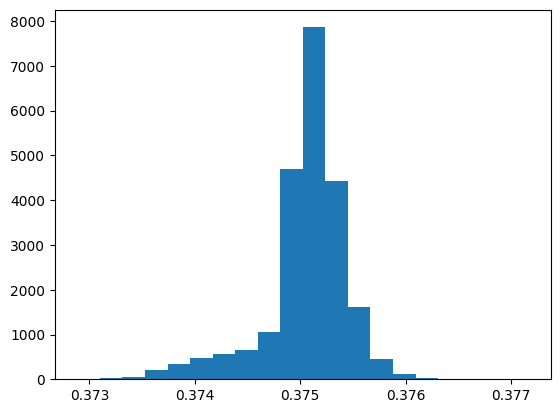

In [23]:
plt.hist(uncertainty, bins=20)

In [8]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.002),
    loss={'task1': cauchy_nll_loss, 'task2': cauchy_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])

/home/mosaic/miniconda3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
3143/3143 [==============================] - 53s 16ms/step - loss: 3.7795 - task1_loss: 1.8900 - task2_loss: 1.8895 - val_loss: 3.6851 - val_task1_loss: 1.8425 - val_task2_loss: 1.8425 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 49s 15ms/step - loss: 3.6274 - task1_loss: 1.8137 - task2_loss: 1.8137 - val_loss: 3.6512 - val_task1_loss: 1.8256 - val_task2_loss: 1.8256 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 52s 16ms/step - loss: 3.5833 - task1_loss: 1.7916 - task2_loss: 1.7916 - val_loss: 3.7229 - val_task1_loss: 1.8614 - val_task2_loss: 1.8614 - lr: 0.0010
Epoch 4/100
3143/3143 [==============================] - 52s 17ms/step - loss: 3.5544 - task1_loss: 1.7772 - task2_loss: 1.7772 - val_loss: 3.5950 - val_task1_loss: 1.7975 - val_task2_loss: 1.7975 - lr: 0.0010
Epoch 5/100
3143/3143 [==============================] - 52s 16ms/step - loss: 3.5309 - task1_loss: 1.7654 - task2_loss: 1.7654 - val_loss: 3.5255 - val_task1_l

In [13]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.001),
    loss={'task1': cauchy_nll_loss, 'task2': cauchy_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])


# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")

/home/mosaic/miniconda3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.7801 - task1_loss: 1.8883 - task2_loss: 1.8918 - val_loss: 3.6420 - val_task1_loss: 1.8210 - val_task2_loss: 1.8210 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.6290 - task1_loss: 1.8145 - task2_loss: 1.8145 - val_loss: 3.5814 - val_task1_loss: 1.7907 - val_task2_loss: 1.7907 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 39s 12ms/step - loss: 3.5860 - task1_loss: 1.7930 - task2_loss: 1.7930 - val_loss: 3.5637 - val_task1_loss: 1.7819 - val_task2_loss: 1.7819 - lr: 0.0010
Epoch 4/100
3143/3143 [==============================] - 39s 13ms/step - loss: 3.5575 - task1_loss: 1.7787 - task2_loss: 1.7787 - val_loss: 3.6588 - val_task1_loss: 1.8294 - val_task2_loss: 1.8294 - lr: 0.0010
Epoch 5/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.5332 - task1_loss: 1.7666 - task2_loss: 1.7666 - val_loss: 3.5759 - val_task1_l

In [11]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.001),
    loss={'task1': cauchy_nll_loss, 'task2': cauchy_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])


# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")

Epoch 1/100
3143/3143 [==============================] - 39s 12ms/step - loss: 3.7452 - task1_loss: 1.8726 - task2_loss: 1.8727 - val_loss: 3.6267 - val_task1_loss: 1.8133 - val_task2_loss: 1.8134 - lr: 0.0020
Epoch 2/100
3143/3143 [==============================] - 38s 12ms/step - loss: 3.6157 - task1_loss: 1.8079 - task2_loss: 1.8079 - val_loss: 3.5704 - val_task1_loss: 1.7852 - val_task2_loss: 1.7852 - lr: 0.0020
Epoch 3/100
3143/3143 [==============================] - 39s 13ms/step - loss: 3.5752 - task1_loss: 1.7876 - task2_loss: 1.7876 - val_loss: 3.5941 - val_task1_loss: 1.7970 - val_task2_loss: 1.7970 - lr: 0.0020
Epoch 4/100
3143/3143 [==============================] - 39s 13ms/step - loss: 3.5448 - task1_loss: 1.7724 - task2_loss: 1.7724 - val_loss: 3.5394 - val_task1_loss: 1.7697 - val_task2_loss: 1.7697 - lr: 0.0020
Epoch 5/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.5235 - task1_loss: 1.7618 - task2_loss: 1.7618 - val_loss: 3.4999 - val_task1_l

In [14]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.001),
    loss={'task1': cauchy_nll_loss, 'task2': cauchy_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])


# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")

/home/mosaic/miniconda3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
3143/3143 [==============================] - 42s 13ms/step - loss: 3.7779 - task1_loss: 1.8874 - task2_loss: 1.8905 - val_loss: 3.7825 - val_task1_loss: 1.8913 - val_task2_loss: 1.8911 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 39s 13ms/step - loss: 3.6309 - task1_loss: 1.8154 - task2_loss: 1.8154 - val_loss: 3.8395 - val_task1_loss: 1.9198 - val_task2_loss: 1.9198 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 41s 13ms/step - loss: 3.5853 - task1_loss: 1.7926 - task2_loss: 1.7926 - val_loss: 3.6133 - val_task1_loss: 1.8066 - val_task2_loss: 1.8066 - lr: 0.0010
Epoch 4/100
3143/3143 [==============================] - 41s 13ms/step - loss: 3.5554 - task1_loss: 1.7777 - task2_loss: 1.7777 - val_loss: 3.5212 - val_task1_loss: 1.7606 - val_task2_loss: 1.7606 - lr: 0.0010
Epoch 5/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.5331 - task1_loss: 1.7665 - task2_loss: 1.7665 - val_loss: 3.5118 - val_task1_l

In [9]:

# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")


81/81 [==============================] - 1s 9ms/step
 MSE Dev = 1.757
 PCC Dev = 0.552
 SCC Dev = 0.588
 MSE Hk = 1.555
 PCC Hk = 0.692
 SCC Hk = 0.546


In [5]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.002),
    loss={'task1': gaussian_nll_loss, 'task2': gaussian_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])


# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")


2024-05-27 13:13:02.383033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 13:13:02.401337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 13:13:02.401511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 13:13:02.402168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Epoch 1/100


2024-05-27 13:13:05.744209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-05-27 13:13:06.457259: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 13:13:06.457749: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 13:13:06.457759: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-27 13:13:06.458092: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-27 13:13:06.458121: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-27 13:13:07.019469: I tensorflow/stream_executor/cuda/c

3143/3143 [==============================] - 41s 12ms/step - loss: 3.7391 - task1_loss: 1.9013 - task2_loss: 1.8377 - val_loss: 3.4736 - val_task1_loss: 1.7405 - val_task2_loss: 1.7331 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.4585 - task1_loss: 1.7294 - task2_loss: 1.7291 - val_loss: 3.5500 - val_task1_loss: 1.7769 - val_task2_loss: 1.7732 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 38s 12ms/step - loss: 3.4001 - task1_loss: 1.7002 - task2_loss: 1.6999 - val_loss: 3.5539 - val_task1_loss: 1.7773 - val_task2_loss: 1.7766 - lr: 0.0010
Epoch 4/100
3143/3143 [==============================] - 38s 12ms/step - loss: 3.3604 - task1_loss: 1.6802 - task2_loss: 1.6802 - val_loss: 3.4397 - val_task1_loss: 1.7199 - val_task2_loss: 1.7198 - lr: 0.0010
Epoch 5/100
3143/3143 [==============================] - 39s 12ms/step - loss: 3.3304 - task1_loss: 1.6652 - task2_loss: 1.6652 - val_loss: 3.3323 - val_task1_loss: 1.6662 

NameError: name 'summary_statistics' is not defined

In [6]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(pred, Y, task):
    if task =="Dev":
        i=0
    if task =="Hk":
        i=1
    mse = mean_squared_error(Y[:,i], pred[:,0])
    pcc = stats.pearsonr(Y[:,i], pred[:,0])[0]
    scc = stats.spearmanr(Y[:,i], pred[:,0])[0]
    print(' MSE ' + task + ' = ' + str("{0:0.3f}".format(mse)))
    print(' PCC ' + task + ' = ' + str("{0:0.3f}".format(pcc)))
    print(' SCC ' + task + ' = ' + str("{0:0.3f}".format(scc)))

# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")


81/81 [==============================] - 0s 6ms/step
 MSE Dev = 1.636
 PCC Dev = 0.577
 SCC Dev = 0.592
 MSE Hk = 1.623
 PCC Hk = 0.678
 SCC Hk = 0.544


In [12]:

keras.backend.clear_session()
gc.collect()


# tasks = ['Dev','Hk']

inputs, outputs = DeepSTARR(input_shape=(L,A))
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    keras.optimizers.Adam(lr=0.001),
    loss={'task1': gaussian_nll_loss, 'task2': gaussian_nll_loss},
    loss_weights={'task1': 1.0, 'task2': 1.0},
    # run_eagerly=True  # Enable eager execution for the model
)

# model.summary()

# early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #'val_aupr',#
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
# reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-7,
                                                mode='min',
                                                verbose=1)

# train model
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es_callback, reduce_lr])


# run for each set and enhancer type
pred = model.predict(x_test, batch_size=512)
results_dev = summary_statistics(pred[0],  y_test, "Dev")
results_hk = summary_statistics(pred[1],  y_test, "Hk")


/home/mosaic/miniconda3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.6674 - task1_loss: 1.8300 - task2_loss: 1.8374 - val_loss: 3.8270 - val_task1_loss: 1.9135 - val_task2_loss: 1.9136 - lr: 0.0010
Epoch 2/100
3143/3143 [==============================] - 39s 12ms/step - loss: 3.4395 - task1_loss: 1.7197 - task2_loss: 1.7198 - val_loss: 3.4118 - val_task1_loss: 1.7059 - val_task2_loss: 1.7058 - lr: 0.0010
Epoch 3/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.3814 - task1_loss: 1.6907 - task2_loss: 1.6907 - val_loss: 3.4163 - val_task1_loss: 1.7081 - val_task2_loss: 1.7082 - lr: 0.0010
Epoch 4/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.3434 - task1_loss: 1.6717 - task2_loss: 1.6717 - val_loss: 3.3799 - val_task1_loss: 1.6900 - val_task2_loss: 1.6900 - lr: 0.0010
Epoch 5/100
3143/3143 [==============================] - 40s 13ms/step - loss: 3.3147 - task1_loss: 1.6574 - task2_loss: 1.6574 - val_loss: 3.3333 - val_task1_l